In [3]:
# Import All Required Libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from os import makedirs, listdir, path
from random import shuffle, seed, random

from PIL import Image
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

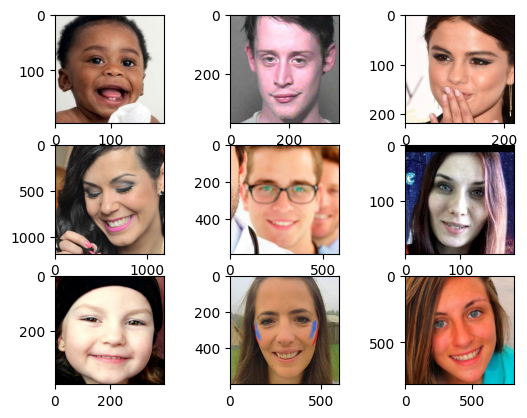

In [8]:
# Define Location Of Dataset And Subfolders
folder = "dataset"
subfolders = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]

# Gather All Image Files
image_files = []

# Choose Emotion To Display
chosen_emotion = "Happy"

# Get All Image Files For Chosen Emotion
for filename in listdir(path.join(folder, f"{chosen_emotion}/")):
  # Get File Name
  name = filename.split("~")[-1]
  # Check If File Is Image
  if (name == f"{chosen_emotion.lower()}.jpg" or name == f"{chosen_emotion.lower()}.png"):
    # Append File To List
    image_files.append(path.join(folder, chosen_emotion, filename))

# Sort Image Files
image_files = sorted(image_files)

# Display Images
for i in range(9):
  # Create Subplot
  plt.subplot(3, 3, i + 1)
  # Check If Index Is Less Than Length Of Image Files
  if i < len(image_files):
    # Load Image
    image = imread(image_files[i])
    # Display Image
    plt.imshow(image)

# Display Plot
plt.show()

In [4]:
# Define Dataset Folder
dataset_folder = "dataset"

finalized_dataset = "finalized_dataset"
subdirs = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]
extensions = [".png", ".jpg"]

for subdir in subdirs:
    subdir_path = os.path.join(dataset_folder, subdir)
    finalized_subdir_path = os.path.join(finalized_dataset, subdir)
    os.makedirs(finalized_subdir_path, exist_ok=True)
    count = 1
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        for extension in extensions:
            if filename.endswith(extension):
                new_filename = f"{subdir.lower()}.{count}{extension}"
                new_file_path = os.path.join(finalized_subdir_path, new_filename)
                os.rename(file_path, new_file_path)
                count += 1
                break

In [14]:
dataset_home = "dataset_emotions"
subdirs = ["train/", "test/"]
labeldirs = ["Angry/", "Happy/", "Neutral/", "Sad/", "Surprise/"]

for subdir in subdirs:
  for labeldir in labeldirs:
    newdir = path.join(dataset_home, subdir, labeldir)
    makedirs(newdir, exist_ok=True)

seed(1)

val_ratio = 0.25

src_directory = "finalized_dataset/"

for labeldir in labeldirs:
    label = labeldir.strip('/')
    label_src_directory = path.join(src_directory, labeldir)
    for file in listdir(label_src_directory):
        src = path.join(label_src_directory, file)
        dst_dir = "train/" if random() >= val_ratio else "test/"
        dst = path.join(dataset_home, dst_dir, labeldir, file)
        copyfile(src, dst)


In [16]:
def define_model():
  model = VGG16(include_top=False, input_shape=(224, 224, 3))

  for layer in model.layers:
    layer.trainable = False

  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(5, activation='softmax')(class1)

  model = Model(inputs=model.inputs, outputs=output)

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

def run_test_harness():
  model = define_model()

  datagen = ImageDataGenerator(featurewise_center=True)

  datagen.mean = [123.68, 116.779, 103.939]

  train_it = datagen.flow_from_directory(
    'dataset_emotions/train/', 
    class_mode='categorical', 
    batch_size=128, 
    target_size=(224, 224)
  )

  test_it = datagen.flow_from_directory(
    'dataset_emotions/test/', 
    class_mode='categorical', 
    batch_size=128, 
    target_size=(224, 224)
  )

  model.fit(
    train_it, 
    validation_data=test_it, 
    steps_per_epoch=len(train_it), 
    validation_steps=len(test_it), 
    epochs=50, 
    verbose=1
  )

  model.save('final_model_emotions.keras')

run_test_harness()

Found 10228 images belonging to 5 classes.
Found 3506 images belonging to 5 classes.
Epoch 1/50


c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_148']. Received: the structure of inputs=*
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.3157 - loss: 7.9791 - val_accuracy: 0.4769 - val_loss: 1.1982
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.4964 - loss: 1.1151 - val_accuracy: 0.5071 - val_loss: 1.1152
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 113us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.5557 - loss: 0.9476 - val_accuracy: 0.5519 - val_loss: 1.0680
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.5943 - loss: 0.8619 - val_accuracy: 0.5627 - val_loss: 1.1765
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.6502 - loss: 0.7472 - val_accuracy: 0.5465 - val_loss: 1.1002


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted category: Angry (75.31%)
Angry: 75.31%
Happy: 0.00%
Neutral: 0.02%
Sad: 24.67%
Surprised: 0.00%


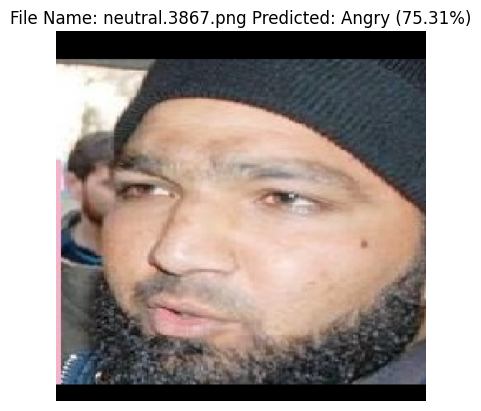

In [4]:
def load_image(filename):
  img = load_img(filename, target_size=(224, 224))
  img = img_to_array(img)
  img = img.reshape(1, 224, 224, 3)
  img = img.astype('float32')
  img = img - [123.68, 116.779, 103.939]
  return img

def load_image(filename):
    img = load_img(filename, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

def run_example(filename):
    img = load_image(filename)
    model = load_model('final_model_emotions.keras')
    result = model.predict(img)
    
    categories = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
    predicted_class = np.argmax(result[0])
    predicted_label = categories[predicted_class]
    predicted_percentage = result[0][predicted_class] * 100
    
    print(f"Predicted category: {predicted_label} ({predicted_percentage:.2f}%)")
    
    for i, category in enumerate(categories):
        print(f"{category}: {result[0][i] * 100:.2f}%")
    
    original_img = load_img(filename, target_size=(224, 224))
    plt.imshow(original_img)
    plt.title(f"File Name: {filename.split("/")[-1]} Predicted: {predicted_label} ({predicted_percentage:.2f}%)")
    plt.axis('off')
    plt.show()

run_example('dataset_emotions/test/Neutral/neutral.3867.png')